# Project Metrics Evaluation

This notebook evaluates and analyzes several aspects of our facial tracking and avatar animation pipeline. 

It demonstrates:
- Extraction of facial metrics (EAR, MAR, lip sync, head pose) using our detectors.
- Mapping of computed metrics to VTube Studio parameters.
- Simulation of FPS calculation.
- Signal smoothing using a 1D Kalman Filter.
- **Additional Evaluations:**
  - Temporal consistency & stability analysis over multiple frames.
  - Smoothing effectiveness: comparing raw vs. Kalman-filtered signals.
  - Latency measurement for metric computation.
  - Statistical analysis (histograms, box plots) of computed metrics.


## Section 1: Setup

Import required libraries and configure logging.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import logging

from detectors.facial_landmarks_processor import FacialLandmarksProcessor
from utils.shared_variables import SharedVariables
from utils.vtube_mapper import map_metrics_to_vts_params
from filter.kalman_filter import KalmanFilter
from utils.calculations import fps_calculation

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Libraries imported and logging configured.")


Libraries imported and logging configured.


## Section 2: Load and Display a Sample Image

Load a sample face image (adjust the `image_path` if necessary) and display it.

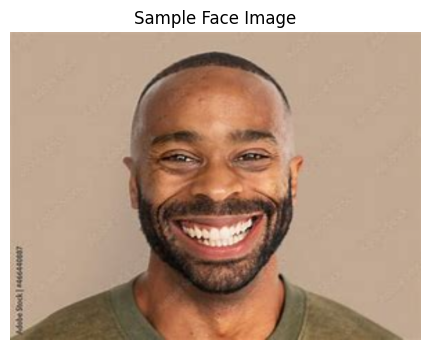

In [17]:
def load_and_display_sample_image(image_path="sample_face.jpg"):
    """
    Loads a sample face image, resizes it, and displays it.
    
    Args:
        image_path (str): Path to the sample image file.
    Returns:
        frame (np.ndarray): The processed BGR image frame, or None on failure.
    """
    frame = cv2.imread(image_path)
    if frame is None:
        logger.error(f"Failed to load sample image at {image_path}.")
        return None
    frame = cv2.resize(frame, (640, 480))
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Sample Face Image")
    plt.axis("off")
    plt.show()
    return frame

# Execute Section 2
frame = load_and_display_sample_image("test.jpg")
if frame is None:
    raise FileNotFoundError("Sample image not found. Ensure 'sample_face.jpg' is in the working directory.")


## Section 3: Evaluate Facial Metrics

Process the loaded image to compute facial metrics using the detector pipeline.

In [18]:
def evaluate_facial_metrics(frame):
    """
    Processes the image frame to compute facial metrics.
    
    Args:
        frame (np.ndarray): An image frame in BGR.
    Returns:
        dict: Computed facial metrics (e.g., EAR, MAR, lip sync, head pose) or an empty dict if no face is detected.
    """
    processor = FacialLandmarksProcessor()
    metrics = processor.process_frame(frame)
    if metrics is None:
        logger.error("No face detected in the sample image!")
        return {}
    else:
        logger.info("Facial metrics computed:")
        for key, value in metrics.items():
            logger.info(f"{key}: {value}")
        print("Computed Facial Metrics:", metrics)
    return metrics

# Execute Section 3
metrics = evaluate_facial_metrics(frame)



INFO:__main__:Facial metrics computed:
INFO:__main__:ear_left: 0.18772099769498002
INFO:__main__:ear_right: 0.19812287334125506
INFO:__main__:mar: 0.24977746903759054
INFO:__main__:ebr_left: 0.8112282578331785
INFO:__main__:ebr_right: 0.8039536450658297
INFO:__main__:lip_sync_value: 0.24977746903759054
INFO:__main__:head_pose: {'rotation_vector': array([[ 4.74541431],
       [-0.12738834],
       [ 0.11790332]]), 'translation_vector': array([[  6.09331871],
       [ 68.49161058],
       [592.30093017]])}


Computed Facial Metrics: {'ear_left': 0.18772099769498002, 'ear_right': 0.19812287334125506, 'mar': 0.24977746903759054, 'ebr_left': 0.8112282578331785, 'ebr_right': 0.8039536450658297, 'lip_sync_value': 0.24977746903759054, 'head_pose': {'rotation_vector': array([[ 4.74541431],
       [-0.12738834],
       [ 0.11790332]]), 'translation_vector': array([[  6.09331871],
       [ 68.49161058],
       [592.30093017]])}}


## Section 4: Map Metrics to VTube Studio Parameters

Map the computed facial metrics to the parameter IDs expected by VTube Studio.

In [19]:
def map_to_vtube_params(metrics):
    """
    Maps computed facial metrics stored in SharedVariables to VTube Studio parameters.
    
    Args:
        metrics (dict): Facial metrics computed earlier.
    Returns:
        dict: Mapping of VTube parameter IDs to computed values.
    """
    shared_vars = SharedVariables()
    if metrics:
        shared_vars.ear_left = metrics.get("ear_left")
        shared_vars.ear_right = metrics.get("ear_right")
        shared_vars.mar = metrics.get("mar")
        shared_vars.lip_sync_value = metrics.get("lip_sync_value")
        head_pose = metrics.get("head_pose", {})
        if head_pose.get("rotation_vector") is not None:
            rot_vec = head_pose.get("rotation_vector")
            shared_vars.yaw = rot_vec[0]
            shared_vars.pitch = rot_vec[1]
            shared_vars.roll = rot_vec[2]
    params = map_metrics_to_vts_params(shared_vars)
    logger.info("Mapped VTube Studio Parameters:")
    for key, value in params.items():
        logger.info(f"{key}: {value}")
    print("VTube Mapping Parameters:", params)
    return params

# Execute Section 4
params = map_to_vtube_params(metrics)


INFO:__main__:Mapped VTube Studio Parameters:
INFO:__main__:ParamMouthOpenY: 0.24977746903759054
INFO:__main__:ParamEyesClosed: 0.8070780644818825
INFO:__main__:ParamHeadYaw: [4.74541431]
INFO:__main__:ParamHeadPitch: [-0.12738834]
INFO:__main__:ParamHeadRoll: [0.11790332]


VTube Mapping Parameters: {'ParamMouthOpenY': 0.24977746903759054, 'ParamEyesClosed': 0.8070780644818825, 'ParamHeadYaw': array([4.74541431]), 'ParamHeadPitch': array([-0.12738834]), 'ParamHeadRoll': array([0.11790332])}


## Section 5: Simulate FPS Calculation

This cell simulates FPS calculation over 100 frames and plots the FPS over time.

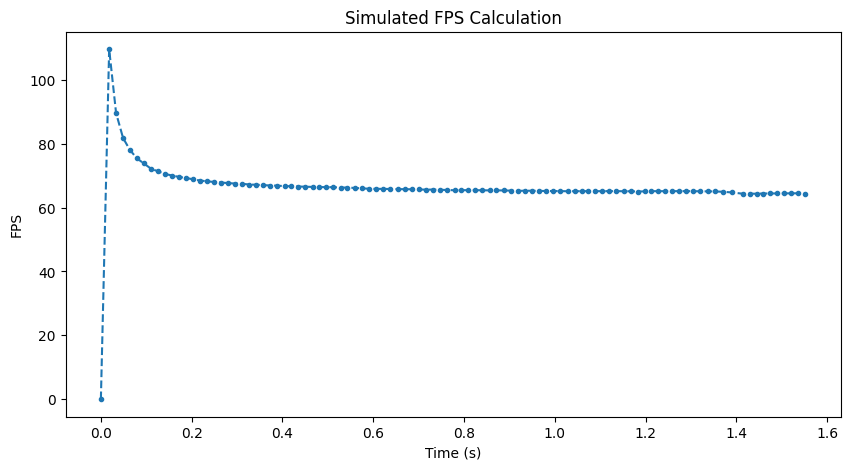

Final FPS: 64.42085487067153


In [20]:
def simulate_fps_calculation():
    """
    Simulates FPS calculation over 100 frames and plots FPS over time.
    """
    start_time = time.time()
    frame_count = 0
    fps_values = []
    time_values = []
    
    for _ in range(100):
        frame_count, fps = fps_calculation(frame_count, start_time)
        fps_values.append(fps)
        time_values.append(time.time() - start_time)
        time.sleep(0.01)  # Simulated delay
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_values, fps_values, marker="o", markersize=3, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("FPS")
    plt.title("Simulated FPS Calculation")
    plt.show()
    
    print("Final FPS:", fps_values[-1])

# Execute Section 5
simulate_fps_calculation()


## Section 6: Demonstrate Kalman Filter Smoothing

This cell demonstrates Kalman Filter smoothing on a simulated noisy signal.

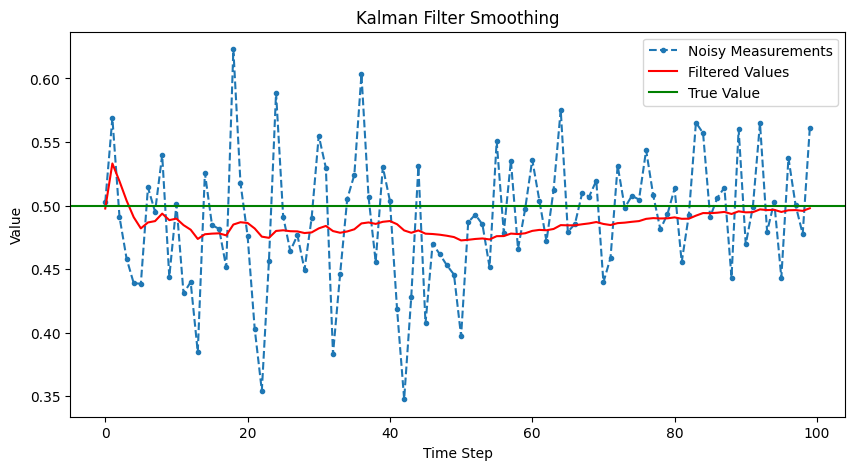

In [21]:
def demonstrate_kalman_filter():
    """
    Demonstrates Kalman Filter smoothing on a noisy signal and plots the results.
    """
    kf = KalmanFilter(process_variance=1e-5, measurement_variance=1e-2, estimated_error=1.0)
    true_value = 0.5
    measurements = true_value + 0.05 * np.random.randn(100)
    filtered_values = []
    for measurement in measurements:
        filtered = kf.update(measurement)
        filtered_values.append(filtered)
    
    plt.figure(figsize=(10, 5))
    plt.plot(measurements, label="Noisy Measurements", marker="o", linestyle="--", markersize=3)
    plt.plot(filtered_values, label="Filtered Values", color="red")
    plt.axhline(true_value, color="green", linestyle="-", label="True Value")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Kalman Filter Smoothing")
    plt.legend()
    plt.show()

# Execute Section 6
demonstrate_kalman_filter()


## Section 7: Temporal Consistency and Stability Analysis

Simulate processing multiple frames (with slight random perturbations) to analyze the temporal stability of computed metrics.

Here we add slight noise to the sample image to simulate frame-to-frame variations and then compute statistics.

ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample image!
ERROR:__main__:No face detected in the sample 

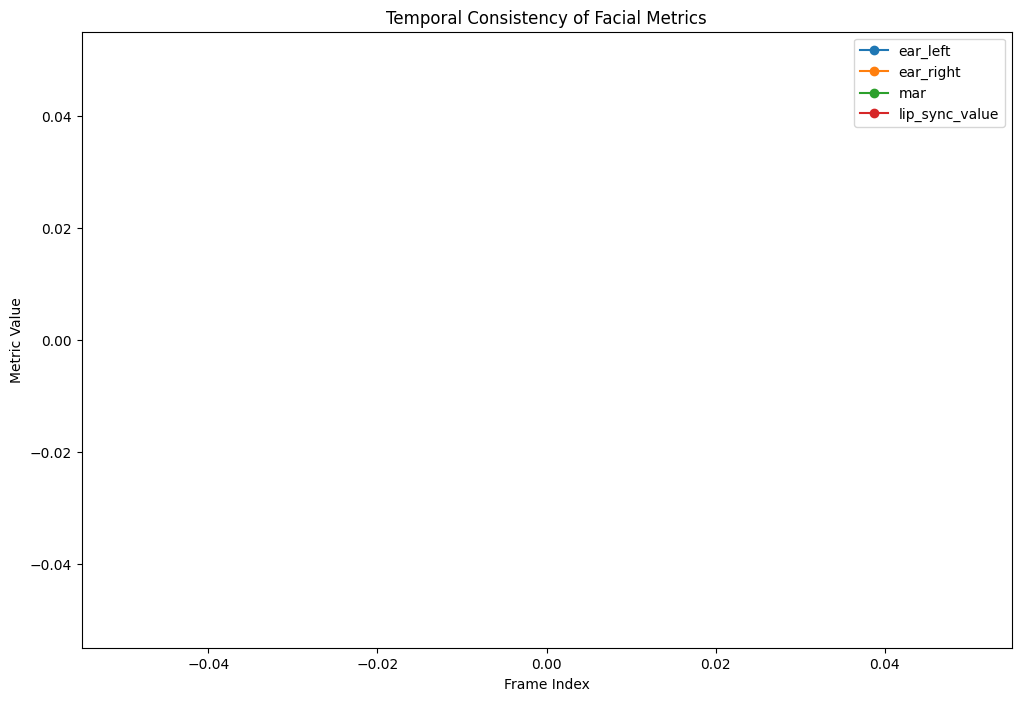

In [25]:
def simulate_temporal_consistency(num_frames=30, noise_level=2):
    """
    Simulates temporal variations by applying random noise (with reduced intensity)
    to the base sample image and computing facial metrics.
    
    Args:
        num_frames (int): Number of frames to simulate.
        noise_level (int): Intensity of the Gaussian noise added (lower value = less noise).
    
    Returns:
        dict: Time-series lists for each key metric.
    """
    base_frame = frame.copy()  # Assumes 'frame' is already loaded correctly.
    metrics_series = {"ear_left": [], "ear_right": [], "mar": [], "lip_sync_value": []}
    
    for i in range(num_frames):
        noisy_frame = base_frame.copy()
        # Add Gaussian noise with reduced intensity
        noise = np.random.normal(0, noise_level, base_frame.shape).astype(np.uint8)
        noisy_frame = cv2.add(noisy_frame, noise)
        
        # Try to compute facial metrics; if none are detected, store NaN.
        metrics = evaluate_facial_metrics(noisy_frame)
        if metrics:
            metrics_series["ear_left"].append(metrics.get("ear_left", np.nan))
            metrics_series["ear_right"].append(metrics.get("ear_right", np.nan))
            metrics_series["mar"].append(metrics.get("mar", np.nan))
            metrics_series["lip_sync_value"].append(metrics.get("lip_sync_value", np.nan))
        else:
            logger.warning(f"Frame {i+1}: No face detected. Storing NaN for this frame.")
            metrics_series["ear_left"].append(np.nan)
            metrics_series["ear_right"].append(np.nan)
            metrics_series["mar"].append(np.nan)
            metrics_series["lip_sync_value"].append(np.nan)
    
    return metrics_series

# Execute Section 7 with reduced noise level
temporal_metrics = simulate_temporal_consistency(num_frames=30, noise_level=2)

# Plot the time-series for each metric
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for metric_name, values in temporal_metrics.items():
    plt.plot(range(len(values)), values, marker='o', label=metric_name)
plt.xlabel("Frame Index")
plt.ylabel("Metric Value")
plt.title("Temporal Consistency of Facial Metrics")
plt.legend()
plt.show()

## Section 8: Smoothing Effectiveness on Simulated EAR Signal

Generate a simulated noisy EAR signal, smooth it with a Kalman Filter, and compare the results.

In [ ]:
def simulate_ear_smoothing(num_steps=50):
    """
    Simulates a noisy EAR signal and applies a Kalman Filter for smoothing.
    
    Args:
        num_steps (int): Number of time steps.
    Returns:
        tuple: (noisy_signal, smoothed_signal)
    """
    # Simulate a "true" EAR value and add noise
    true_ear = 0.2  # Typical EAR for an open eye
    noisy_signal = true_ear + 0.05 * np.random.randn(num_steps)
    kf = KalmanFilter(process_variance=1e-5, measurement_variance=1e-2, estimated_error=1.0)
    smoothed_signal = []
    for measurement in noisy_signal:
        smoothed_signal.append(kf.update(measurement))
    return noisy_signal, smoothed_signal

# Execute Section 8
noisy_ear, smoothed_ear = simulate_ear_smoothing(num_steps=50)
plt.figure(figsize=(10, 5))
plt.plot(noisy_ear, label="Noisy EAR", marker="o", linestyle="--")
plt.plot(smoothed_ear, label="Smoothed EAR", color="red")
plt.xlabel("Time Step")
plt.ylabel("EAR Value")
plt.title("Simulated EAR Smoothing with Kalman Filter")
plt.legend()
plt.show()



## Section 9: Latency Measurement for Facial Metrics Computation

Measure the average time taken to compute facial metrics over multiple runs.

In [ ]:
def measure_latency(num_runs=10):
    """
    Measures the average latency of the facial metrics computation.
    
    Args:
        num_runs (int): Number of runs to average.
    Returns:
        float: Average latency in seconds.
    """
    latencies = []
    for _ in range(num_runs):
        start = time.time()
        _ = evaluate_facial_metrics(frame)
        latencies.append(time.time() - start)
    avg_latency = np.mean(latencies)
    print(f"Average computation latency over {num_runs} runs: {avg_latency:.4f} seconds")
    return latencies

# Execute Section 9
_ = measure_latency(num_runs=10)



## Section 10: Statistical Analysis of Computed Metrics

Display histograms and box plots of the temporal metrics collected.

In [ ]:
import seaborn as sns

def statistical_analysis(metrics_series):
    """
    Generate histograms and box plots for the simulated temporal metrics.
    
    Args:
        metrics_series (dict): Dictionary of metric lists.
    """
    for metric_name, values in metrics_series.items():
        plt.figure(figsize=(12, 4))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(values, kde=True)
        plt.title(f"Histogram of {metric_name}")
        plt.xlabel(metric_name)
        plt.ylabel("Frequency")
        
        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=values)
        plt.title(f"Box Plot of {metric_name}")
        
        plt.tight_layout()
        plt.show()

# Execute Section 10
statistical_analysis(temporal_metrics)



## Conclusion

In this extended evaluation, we have:
- Extracted facial metrics from a sample image and mapped them to VTube Studio parameters.
- Simulated FPS calculation and demonstrated signal smoothing with a Kalman Filter.
- Analyzed temporal consistency and stability over multiple frames.
- Compared raw and filtered measurements on a simulated signal.
- Measured latency per computation and performed statistical analyses on the metrics.
